In [1]:
from transformer_lens import HookedTransformer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "gpt2"
model = HookedTransformer.from_pretrained(model_name, device = device)

/root/sae-rm/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/sae-rm/logan/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [2]:
from sparsifiers import SAE
from huggingface_hub import hf_hub_download

layer = 6
# e2e_name = "https://huggingface.co/apollo-research/e2e-saes-gpt2/blob/main/downstream_similar_ce_layer_6.pt"
downstream_name = f"downstream_similar_ce_layer_{layer}.pt"
# downstream_name = f"downstream_similar_l0_layer_{layer}.pt"
e2e_name = f"e2e_similar_ce_layer_{layer}.pt"
# e2e_name = f"e2e_similar_l0_layer_{layer}.pt"
local_name = f"local_similar_ce_layer_{layer}.pt"
# local_name = f"local_similar_l0_layer_{layer}.pt"


activation_name = f"transformer.h.{layer}"
model_id = "apollo-research/e2e-saes-gpt2"



In [3]:
def load_sae(model_id, hh_file_location):
    ae_download_location = hf_hub_download(repo_id=model_id, filename=hh_file_location)

    sae_list = torch.load(ae_download_location)

    # Rename the keys in the state dictionary
    def rename_keys(state_dict):
        renamed_state_dict = {}
        for key, value in state_dict.items():
            if key == 'encoder.weight':
                renamed_state_dict['encoder.0.weight'] = value
            elif key == 'encoder.bias':
                renamed_state_dict['encoder.0.bias'] = value
            else:
                renamed_state_dict[key] = value
        return renamed_state_dict

    # Create an instance of the SAE model with the extracted parameters
    n_dict_components, input_size = sae_list['encoder.weight'].shape
    sae = SAE(input_size=input_size, n_dict_components=n_dict_components)

    # Rename the keys in the state dictionary
    renamed_sae_list = rename_keys(sae_list)

    # Load the state dictionary into the model instance
    sae.load_state_dict(renamed_sae_list)
    return sae
sae_local = load_sae(model_id, local_name).to(device)
sae_downstream = load_sae(model_id, downstream_name).to(device)
sae_e2e = load_sae(model_id, e2e_name).to(device)

In [4]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange

def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

dataset_name = "stas/openwebtext-10k"
max_seq_length = 40
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=model.tokenizer, max_length=max_seq_length, num_datapoints=2000) # num_datapoints grabs all of them if None


Map: 100%|██████████| 2000/2000 [00:01<00:00, 1354.83 examples/s]


In [5]:

# now run through the model & grab activations to get dead features
def get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32):
    device = model.cfg.device
    num_features, d_model = autoencoder.encoder[0].weight.shape
    datapoints = dataset.num_rows
    dictionary_activations = torch.zeros((datapoints*max_seq_length, num_features))
    token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            batch = batch.to(device)
            token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
            # with Trace(model, cache_name) as ret:
            #     _ = model(batch).logits
            #     internal_activations = ret.output
            #     # check if instance tuple
            #     if(isinstance(internal_activations, tuple)):
            #         internal_activations = internal_activations[0]
            _, cache = model.run_with_cache(batch)
            # print(cache)
            internal_activations = cache[cache_name]
            batched_neuron_activations = rearrange(internal_activations, "b s n -> (b s) n" )
            batched_dictionary_activations = autoencoder.encoder(batched_neuron_activations)
            dictionary_activations[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length,:] = batched_dictionary_activations.cpu()
    return dictionary_activations, token_list

batch_size = 128
activation_name = f"blocks.{layer}.hook_resid_post"
nz_indices = []
for sae in [sae_local, sae_downstream, sae_e2e]:
    dictionary_activations, _ = get_dictionary_activations(model, dataset, activation_name, max_seq_length, sae, batch_size=batch_size)
    nz_indices.append((dictionary_activations.sum(0) != 0).nonzero()[:, 0])

100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


In [6]:
for nz_ind in nz_indices:
    print(nz_ind.shape)

torch.Size([26912])
torch.Size([15026])
torch.Size([20699])


In [10]:
do_decoder = True

if(do_decoder):
    dec_local = sae_local.decoder.weight.data
    dec_downstream = sae_downstream.decoder.weight.data
    dec_e2e = sae_e2e.decoder.weight.data
else:
    dec_local = sae_local.encoder[0].weight.data.T
    dec_downstream = sae_downstream.encoder[0].weight.data.T
    dec_e2e = sae_e2e.encoder[0].weight.data.T

dec_local = dec_local / dec_local.norm(dim=0, keepdim=True)
dec_downstream = dec_downstream / dec_downstream.norm(dim=0, keepdim=True)
dec_e2e = dec_e2e / dec_e2e.norm(dim=0, keepdim=True)

In [11]:
from scipy.optimize import linear_sum_assignment
def get_max_cos_sim(decoder_1, decoder_2, max_features_for_compute = 10000):
    N = max_features_for_compute
    ddec = decoder_1[:, :N]
    ddec2 = decoder_2[:, :N]
    cos = (ddec.T@ddec2).cpu().numpy()
    cos = 1 - cos
    row_ind, col_ind = linear_sum_assignment(cos)
    # row_ind, col_ind = linear_sum_assignment(cos.T)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos[row_ind, col_ind]
    return max_cosine_similarities
saes_in_list = [dec_local[:, nz_indices[0]], dec_downstream[:, nz_indices[1]], dec_e2e[:, nz_indices[2]]]
max_features_for_compute = 10000
# do all combinatorics of decoders (should be 3)
max_cos_similarities = []
for i in range(len(saes_in_list)):
    for j in range(i+1, len(saes_in_list)):
        max_cos_similarities.append(get_max_cos_sim(saes_in_list[i], saes_in_list[j], max_features_for_compute))

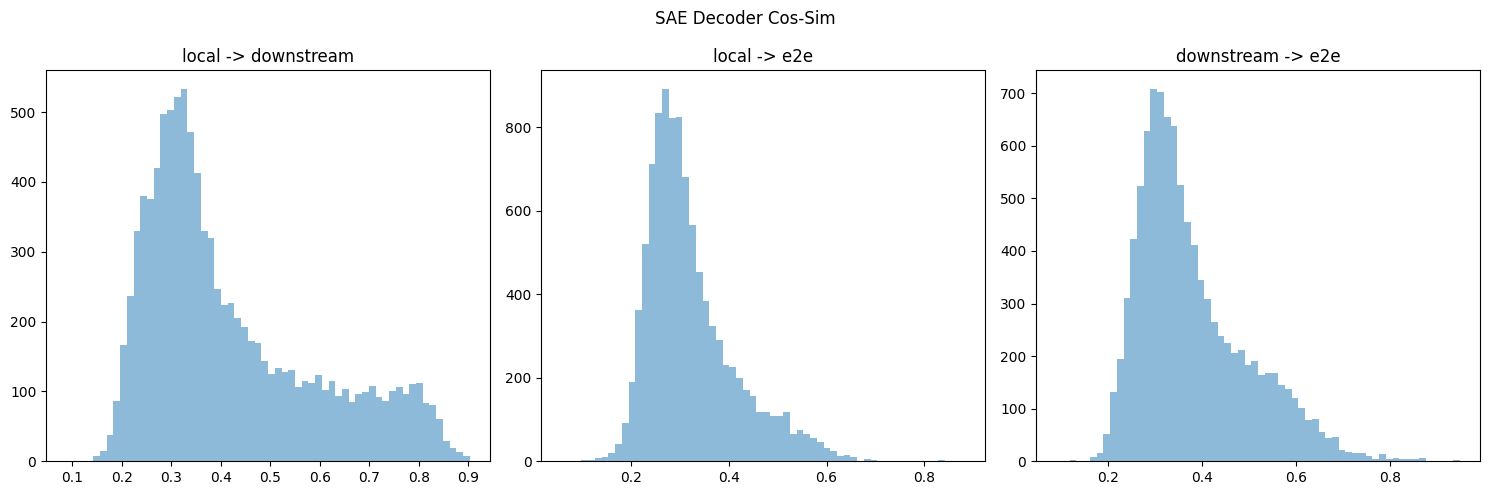

In [12]:
import matplotlib.pyplot as plt

# Assuming max_cos_similarities is a list of lists containing the data
# Example: max_cos_similarities = [[data1], [data2], [data3]]

encoder_names = ["local", "downstream", "e2e"]
num_encoders = len(encoder_names)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define the pairs and corresponding labels
pairs = [(0, 1), (0, 2), (1, 2)]
labels = ["local -> downstream", "local -> e2e", "downstream -> e2e"]

# Create subplots
for idx in range(3):
    i, j = pairs[idx]
    axes[idx].hist(max_cos_similarities[idx], bins=60, alpha=0.5, label=labels[idx])
    axes[idx].set_title(labels[idx])

# Adjust layout
plt.suptitle("SAE Decoder Cos-Sim")
plt.tight_layout()
plt.show()

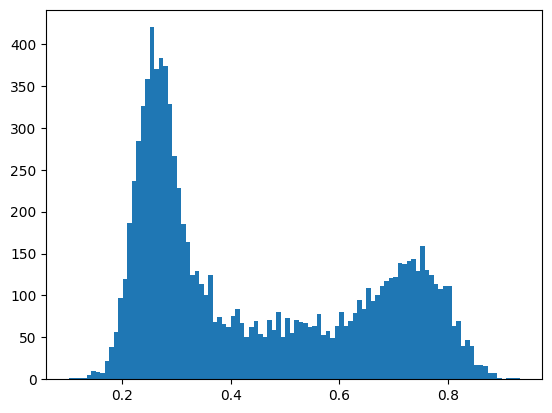

In [63]:
# plot hist of values
# Maybe also check only dead features? 
import matplotlib.pyplot as plt
plt.hist(max_cosine_similarities, bins=100)
plt.show()

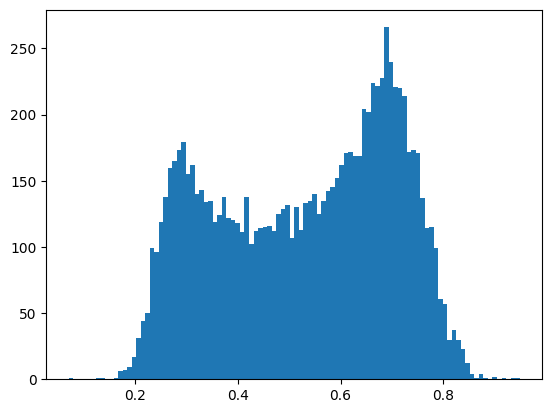

In [67]:
# plot hist of values
# Maybe also check only dead features? 
import matplotlib.pyplot as plt
plt.hist(max_cosine_similarities, bins=100)
plt.show()

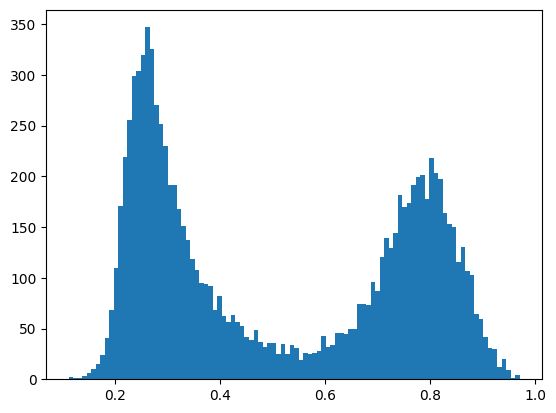

In [65]:
# plot hist of values
# Maybe also check only dead features? 
import matplotlib.pyplot as plt
plt.hist(max_cosine_similarities, bins=100)
plt.show()

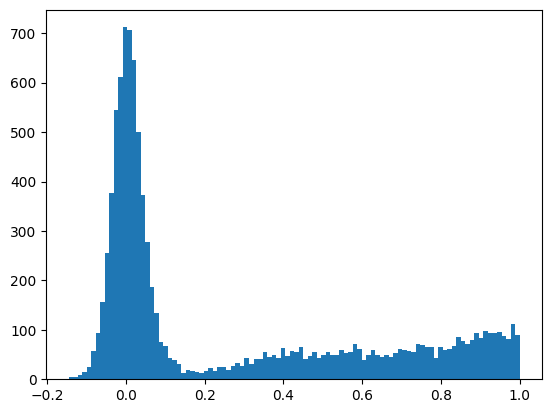

In [37]:
# plot hist of values
# Maybe also check only dead features? 
import matplotlib.pyplot as plt
plt.hist(max_cosine_similarities, bins=100)
plt.show()

In [15]:
cos_sims = (dec.T@dec2)


In [7]:
ddec = dec[:, :]
ddec2 = dec2[:, :]
cos = (ddec.T@ddec2)
cos

tensor([[ 0.8259,  0.0525],
        [-0.0195,  0.0168]], device='cuda:0')

In [13]:
ddec.norm(dim=0), ddec2.norm(dim=0)

(tensor([1.0000, 1.0000], device='cuda:0'),
 tensor([1.0000, 1.0000], device='cuda:0'))

In [55]:
for x in dec:
    print(x.shape)
    break

torch.Size([46080])


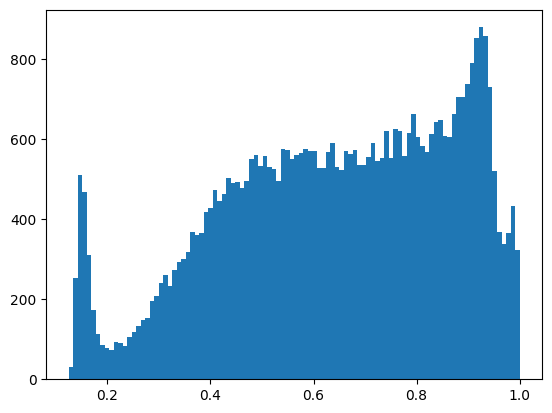

In [44]:
# plot hist of values
# Maybe also check only dead features? 
import matplotlib.pyplot as plt
cos_sims = (dec2.T@dec)
plt.hist(cos_sims.max(0).values.cpu().numpy(), bins=100)
plt.show()

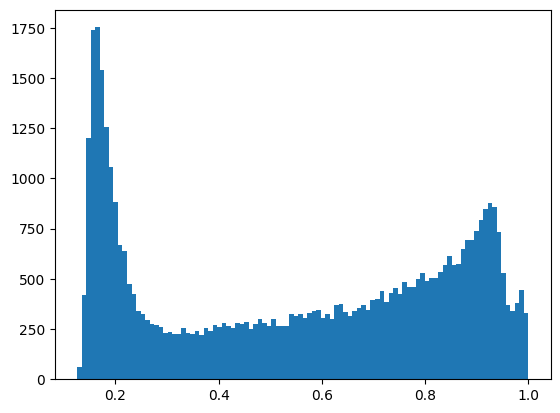

In [43]:
# plot hist of values
# Maybe also check only dead features? 
import matplotlib.pyplot as plt
cos_sims = (dec.T@dec2)
plt.hist(cos_sims.max(0).values.cpu().numpy(), bins=100)
plt.show()

In [26]:
sae_list["encoder.weight"].shape, sae_list["encoder.bias"].shape, sae_list["decoder.weight"].shape, sae_list["decoder.bias"].shape, sae.decoder.bias.shape

(torch.Size([46080, 768]),
 torch.Size([46080]),
 torch.Size([768, 46080]),
 torch.Size([768]),
 torch.Size([46080]))

In [ ]:
# Alternative:
# Now load in the pretrained SAE to the new model
trainable_param_names = load_pretrained_saes(
    saes=new_model.saes,
    pretrained_sae_paths=new_config.saes.pretrained_sae_paths,
    all_param_names=[name for name, _ in new_model.saes.named_parameters()],
)

pretrained_sae_params = {}
for pretrained_sae_path in pretrained_sae_paths:
    # Add new sae params (note that this will overwrite existing SAEs with the same name)
    pretrained_sae_params = {**pretrained_sae_params, **torch.load(pretrained_sae_path)}
sae_state_dict = {**dict(saes.named_parameters()), **pretrained_sae_params}

saes.load_state_dict(sae_state_dict)